# An analysis of possible factors contributing to survivability among passengers on the Titanic's ill-fated maiden voyage.
__by Christopher Ivanovich__

Initial questions regarding survival likelihood between different groups of passengers:
1. How do survival and mortality vary with regard to economic strata?
2. How does it vary across gender? 
3. Across age?

But, before we can go further into these questions, we must acquire some baseline population parameters against which we can draw later comparisons.

In [1]:
import pandas as pd
import numpy as np
import seaborn
%pylab inline
import matplotlib.pyplot as plt

df = pd.read_csv("titanic-data.csv")
df.describe()

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We see immediately that some NaNs have been propagated into the Age field, preventing our description function from generating quartile output. We make note of this, and will be sure to drop any NaNs from age-related calculations later.

In [2]:
#for our later reference
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
survivors = df[df.Survived==1]
dead = df[df.Survived==0]
print(str(len(dead)) + " passengers lost their lives, while " + str(len(survivors)) + 
      " survived.")

549 passengers lost their lives, while 342 survived.


# Of the 892 embarkees, only 342 survived the ship's capsizing, a survival rate of about 38%.

From our basic descriptive stats table, we see an average age of 29.70, with an age range of 79.58 years across all passengers for which there are age data.

Let's take a look at how survivability varies with regard to gender, with regard to age, and with regard to both at the same time.



In [4]:
males = survivors[survivors["Sex"]=="male"]
females = survivors[survivors["Sex"]=="female"]
print("Of the male passengers, {0} out of {1} survived, or roughly 1 in 5."
      .format(str(len(males)),str(len(df[df["Sex"]=="male"]))))
print("Of the female passengers, {0} out of {1} survived, or roughly 2 in 3."
      .format(str(len(females)),str(len(df[df["Sex"]=="female"]))))

Of the male passengers, 109 out of 577 survived, or roughly 1 in 5.
Of the female passengers, 233 out of 314 survived, or roughly 2 in 3.


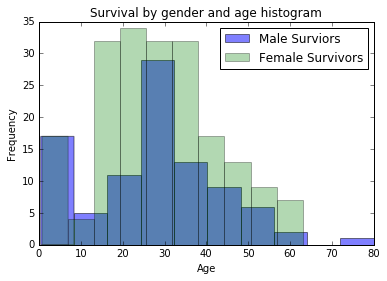

In [5]:
import matplotlib.pyplot as plt
plt.title("Survival by gender and age histogram")
plt.hist(males.Age.dropna(), alpha=.5)
plt.hist(females.Age.dropna(), alpha=.3)
plt.legend(["Male Surviors","Female Survivors"])
plt.xlabel("Age"); plt.ylabel("Frequency")
plt.show()

We see above that a major determinant of survivability seems to have been gender, with women far more likely to survive than men (on the Titanic, it appears that "women and children first!" was truly in effect). Children of both genders appear to have done well, but without comparing the ratio of survivors by age to the total number of passengers in an age group, it is difficult to say that one age group fared better than another.

Thus, below, we introduce a column of age ranges for passengers, with ages split into groups that might have bearing on passenger survivability. We define an age range of 0-14 for "children first", and subsequent ranges according to what are commonly regarded as life's stages of development and aging.


In [8]:
age_ranges = pd.cut(df.Age, [0, 14, 25, 40, 55, 75, 100], labels = ["0-14", "15-25", "26-40", "41-55", "56-75", "75+"])
df["age_range"]= age_ranges
survived = df[df.Survived==1]
rates = round(survived.age_range.value_counts()/df.age_range.value_counts(), 3)
#counting survivors by age group, dividing by total passengers in that age group.
survival_groups = pd.DataFrame(rates)
survival_groups.rename(columns={"age_range": "Survival proportion"}, inplace=True)
survival_groups["Number of survivors"]=survived.age_range.value_counts()
survival_groups["Total passengers"]=df.age_range.value_counts()
survival_groups

,Survival proportion,Number of survivors,Total passengers
0-14,0.584,45,77
15-25,0.353,79,224
26-40,0.422,111,263
41-55,0.391,43,110
56-75,0.282,11,39
75+,1.000,1,1


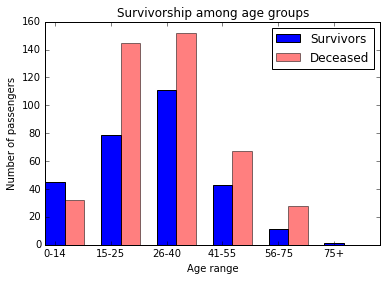

In [9]:
# plt.hist(survival_groups)
fig, ax = plt.subplots()
idx = np.arange(len(survival_groups))
barwidth = .35
ax.bar(idx, survival_groups["Number of survivors"], 
                width=barwidth, color='b')
ax.bar(idx+barwidth, survival_groups["Total passengers"]-survival_groups["Number of survivors"],
       width=barwidth, color='r', alpha=.5)
plt.xticks(idx + barwidth / 2, survival_groups.index)
plt.xlabel("Age range"); plt.ylabel("Number of passengers")
plt.title("Survivorship among age groups")
plt.legend(["Survivors", "Deceased"])

Not counting the elderly outlier painfully obvious in the above bar chart, the previous table indicates that children aged 0-14 years old had a survival rate of 58%, the highest of any age group as they are defined here. The next highest group contains those aged from 26-40 years old.

The logic of defining "children" as being between 0-14 years old is non-scientific, but it is intended to reflect a common sense notion of whether people would be willing to give up their chance at survival for someone younger than themselves. 

The other groups reflect assumptions about relative health and fitness, but it is interesting that the group, 26-40, had a substantially higher survival rate than those aged 15-25.

This observation leads me to hypothesize that passengers of means (i.e. those inhabiting a higher economic stratum) skewed older than those of lesser means, and we would expect to see that a higher proportion of passengers in the 26-40 group are in the highest class category, as compared to those aged 15-25.

In [13]:
mean_class_by_age_group = df.groupby("Survived")["Pclass"].mean().rename("Survival Class Mean") ##1, 2, 3 for pclass
mean_count_by_ticket_class = df.groupby("Survived")["Pclass"].count().rename("Survival class Count")
print(mean_class_by_age_group)
print('\n')
print(mean_count_by_ticket_class)

Survived
0    2.531876
1    1.950292
Name: Survival Class Mean, dtype: float64


Survived
0    549
1    342
Name: Survival class Count, dtype: int64


Not terribly surprising results, though perhaps in need of inferential analysis for further support. Based on a simple mean of only three possible values (thus, no outliers) which reflect the class category of a ticket (1st, 2nd, and 3rd class), we see that the mean ticket class for those who did not survive is about 2.53. More tellingly, those who survived had a mean ticket class of 1.95. As we saw in our initial descriptive statistics query of the total dataset, the mean for the entire population is about 2.38, midway been the means for survivors and non-survivors. Is this difference between the population class mean and survival class mean due to random chance?

In [14]:
import scipy.stats as ss #ss.ttest_ind, ss.zscore

living_classes = df[df["Survived"]==1].groupby(["Pclass"]).size()
all_classes = df.groupby(["Pclass"]).size()
print(ss.chisquare(all_classes, living_classes))
print(all_classes, living_classes)

Power_divergenceResult(statistic=1318.0990051192889, pvalue=6.0039592682543623e-287)
Pclass
1    216
2    184
3    491
dtype: int64 Pclass
1    136
2     87
3    119
dtype: int64


We note that the sum of values for the survivors class counts is 342: matching our previous value, this tells us that there were no pesky NaNs left out by our analysis.

What do the results of the chi-square test, in which we compare the membership in particular class categories of the population against our group of survivors (treating the survivors as a random sample drawn from the population), suggest to us? Given the absurdly small p-value, the chi-square test tells us that the deviation from the population distribution is almost certainly not due to random chance: One's particular class seems to have impacted one's ability to survive, all else being equal.

Given the larger number of people who did not make it to the infamously inadequate number of lifeboats, we expect perhaps to see larger variation throughout the population of those who did not survive as opposed to those who did. We certainly expect to see less variation among survivers with regard to ticket class.

In [26]:
age_fare = df[["Survived", "Pclass", "Age","Fare"]].dropna()
age_fare = age_fare[age_fare["Fare"]>0] #to remove passengers riding for free, or marked as such
print("Mean values for Age and Fare, across Survival and Pclass")
age_fare.pivot_table(aggfunc='mean', columns=["Survived","Pclass"])

Mean values for Age and Fare, across Survival and Pclass


      Survived  Pclass
Age   0         1         43.926230
                2         33.544444
                3         26.464419
      1         1         35.368197
                2         25.901566
                3         20.594286
Fare  0         1         70.668918
                2         20.754953
                3         13.328104
      1         1         98.770904
                2         22.248595
                3         13.545783
dtype: float64

We see here some of what we've expected: after dropping NaNs appearing in our data of interest (Pclass, Age, Fare, and Survived), those of the lowest class (assuming wealthier people weren't simply scrounging on ticket expenditures--a fair assumption for Victorian England and the likely conditions of the 3rd and 2nd class quarters) skew younger than the other classes, and those in the 1st class category skew substantially older, regardless of survival. Also, somewhat supporting the prediction that age played a factor in survival within distinct class categories, we see that mean age for survivors is younger than for those who perished, across all 3 classes. 

Also, we noted and dealt with a problem in the fares data: minimum values included 0, meaning some passengers may have received free tickets, or that 0 is a substitution for an NaN, making ticket prices and perhaps even Pclass a poor gauge of economic stratum if those values are included. Thus, they've been filtered from the data passed to the pivot table, as can be seen in the previous code.

In [27]:
rich_survivors = survivors.where(survivors["Pclass"]==1)

ss.ttest_ind(df["Age"].dropna(), rich_survivors["Age"].dropna())

Ttest_indResult(statistic=-4.0136433432380265, pvalue=6.5169222763279379e-05)

Running a t-test to compare mean values for age between our passenger population and that of 1st class survivors yields a t-stat value of -4.0136433432380265, with an astronomically small p-value of 6.516922276327938e-05. This strongly (but not definitively) suggests that our observation is not due to random chance, which in turn might co-correlate with our observation that first-class passengers were more likely to survive, and that first-class passengers were on average older than passengers in other PClass groups. To test this further, we would need to run multivariate regression of some sort.

# Discussion of Results

So, what can we learn from these inquiries into the historical Titanic's passenger data (courtesy of Kaggle)?

By splitting up the data by gender, age, and Pclass, and then comparing survival rates across different sub-groups, we seem to have shed some light on survivability. 

First, we noted that gender seems to have played a key role in the likelihood of securing a spot on a lifeboat--women across all ages seem to have had a higher survival rate than men (including among children). The somewhat patriarchal notion of "women and children first" seems to have won out, to the credit of the men onboard, even in such confused times as ours (though, if the notion were in full effect, we'd expect the male survival rate to be limited to children). Our histogram, which includes age bins, seems to have had to produce more bins for females than males, suggesting their was greater clustering of ages than was present in the male population (e.g., age among the males was more widely distributed). 

Then, in our consideration of survivorship among our pre-defined age groups (based on a somewhat arbitrary notion of who could fairly be called a child in those times, who an able-bodied adult, and so on), we saw that age seems to have been a strong factor in survivability/mortality, but then we also recognized that age is unlikely to have played a role in isolation--class differences and age seem to have been noticeably entangled.

We thus more finely broke up our data in distinct class groups along survival-non-survival lines. Descriptive statistics from this data with regard to age allowed us to make some finer predictions, which we were then able to test somewhat with the use of the t and chi-squared distributions.

## Possible biases inherent in the data collection
As caveats, it must be noted that the data we have may be quite unreliable--they are based on historical records, gathered in a non-rigorous fashion, and are difficult if not impossible to verify (even if it were possible, the difficult of doing so would likely require the efforts of highly focused historical scholars). Ages could have been lied about, or improperly recorded. Ticket prices and cabin positions are poor proxies for class membership, and class categories themselves are arbitrary. A more rigorous means of assigning such categories could take into account assets and wealth records--but, such records are likely non-existent for all of the passengers in the dataset, particularly those of less means.

## Further questions we might have asked
1. What role does cabin assignment play? We can reasonably surmise that proximity to life boats affected survival.
2. Did having children make a difference for survival among adults (e.g., more of fewer children affected the likelihood of survival? What about gender of the parent?)?
3. Did embarkation point have a role to play as well? As unlikely as that seems, it is still worth investigating--perhaps people from the same embarkation point were clustered together, which would relate to cabin location, for instance.